
Evolving Original System (2-2-1):
Time Step 0: System Energy = 0.522169
Time Step 1000: System Energy = 0.250044
Time Step 2000: System Energy = 0.250250
Time Step 3000: System Energy = 0.250116
Time Step 4000: System Energy = 0.264199

Predictions on new states:
Input: [0.5, 0.5] -> State Probability: 0.5125
Input: [0.2, 0.8] -> State Probability: 0.5125
Input: [0.7, 0.3] -> State Probability: 0.5125
Input: [0.9, 0.1] -> State Probability: 0.5125

Evolving Three-Node Hidden Layer (2-3-1):
Time Step 0: System Energy = 0.507167
Time Step 1000: System Energy = 0.250331
Time Step 2000: System Energy = 0.251028
Time Step 3000: System Energy = 0.250066
Time Step 4000: System Energy = 0.269717

Predictions on new states:
Input: [0.5, 0.5] -> State Probability: 0.4663
Input: [0.2, 0.8] -> State Probability: 0.4663
Input: [0.7, 0.3] -> State Probability: 0.4663
Input: [0.9, 0.1] -> State Probability: 0.4663

Evolving Two Hidden Layers (2-2-2-1):
Time Step 0: System Energy = 0.542717
Time Step

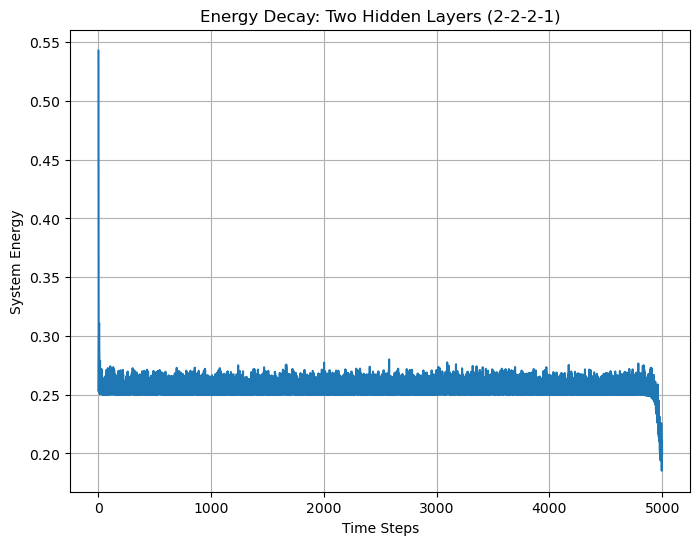

Saved: figures\energy_decay_Two_Hidden_Layers_(2-2-2-1).png


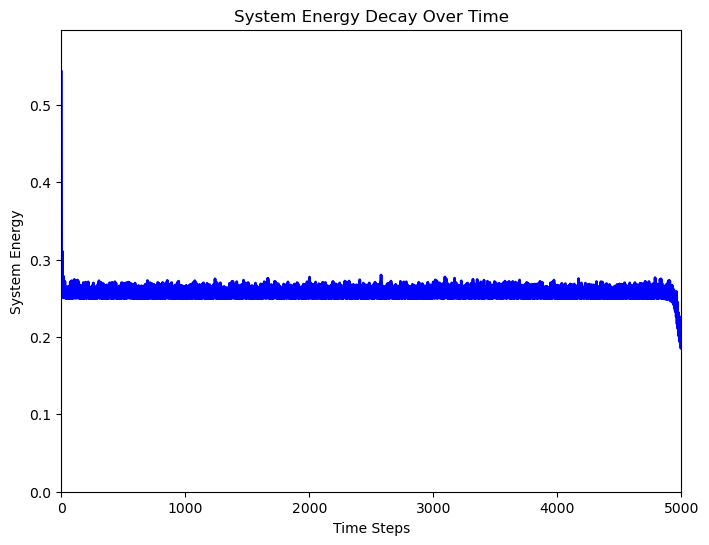

Saved animation: figures\energy_anim_Two_Hidden_Layers_(2-2-2-1).gif


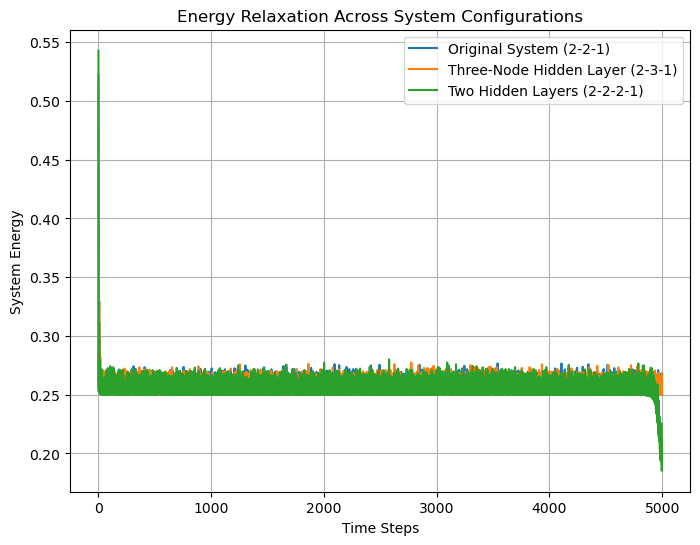

Saved: figures\energy_comparison.png

Verifying feedforward with given weights:
0.9996646498695336
0.7216325609518421

Simulation complete. All static plots, GIFs, and console outputs are saved in 'figures/' and printed above.

Generating Phase Diagram Evolution animation...


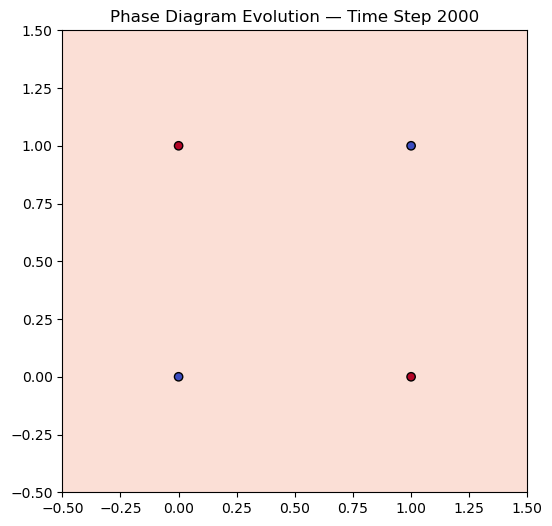

Saved phase diagram animation: figures\phase_diagram_evolution.gif


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Output folder
os.makedirs("figures", exist_ok=True)

def save_and_show(fig, filename):
    filepath = os.path.join("figures", filename)
    fig.savefig(filepath, dpi=150, bbox_inches='tight')
    plt.show(fig)
    print(f"Saved: {filepath}")

# Activation Functions
def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
def sigmoid_derivative(a): return a * (1.0 - a)

def tanh(x): return np.tanh(x)
def tanh_derivative(a): return 1.0 - a**2

def relu(x): return np.maximum(0, x)
def relu_derivative(a): return (a > 0).astype(float)

ACT_FUNCS = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'tanh': (tanh, tanh_derivative),
    'relu': (relu, relu_derivative)
}

# Neuron
class Neuron:
    def __init__(self, weights, bias, activation='sigmoid'):
        self.weights = weights
        self.bias = bias
        self.activation_name = activation
        self.activation, self.activation_deriv = ACT_FUNCS[activation]
        
    def feedforward(self, inputs):
        self.z = np.dot(self.weights, inputs) + self.bias
        self.a = self.activation(self.z)
        return self.a

# Neural Network
class NeuralNetwork:
    def __init__(self, architecture, activation='sigmoid'):
        self.architecture = architecture
        self.layers = []
        self.activation_name = activation
        
        for i in range(len(architecture) - 1):
            layer_neurons = []
            for _ in range(architecture[i+1]):
                weights = np.random.randn(architecture[i]) * 0.1
                bias = np.random.randn() * 0.1
                layer_neurons.append(Neuron(weights, bias, activation))
            self.layers.append(layer_neurons)
        
        self.velocities_w = [[np.zeros_like(n.weights) for n in layer] for layer in self.layers]
        self.velocities_b = [[0.0 for _ in layer] for layer in self.layers]

    def feedforward(self, x):
        activations = [x]
        for layer in self.layers:
            layer_output = []
            for neuron in layer:
                layer_output.append(neuron.feedforward(activations[-1]))
            activations.append(np.array(layer_output))
        return activations[-1], activations

    def train(self, X, y, learning_rate=0.1, epochs=5000, batch_size=None,
              momentum=0.0, early_stopping=False, patience=10, tol=1e-4, verbose=False):
        
        y = np.array(y).reshape(-1, 1)
        energies = []
        best_energy = float('inf')
        patience_counter = 0
        
        n_samples = len(X)
        if batch_size is None:
            batch_size = n_samples
        
        for epoch in range(epochs):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y[indices]
            
            total_energy = 0.0
            
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
                
                grad_w = [[np.zeros_like(n.weights) for n in layer] for layer in self.layers]
                grad_b = [[0.0 for _ in layer] for layer in self.layers]
                
                for input_data, target in zip(X_batch, y_batch):
                    output, all_activations = self.feedforward(input_data)
                    error = target - output
                    total_energy += np.sum(error**2)
                    
                    deltas = []
                    output_delta = error * ACT_FUNCS[self.activation_name][1](output)
                    deltas.append(output_delta)
                    
                    for i in range(len(self.layers)-2, -1, -1):
                        layer_deltas = []
                        current_activations = all_activations[i+1]
                        for j in range(len(self.layers[i])):
                            error_sum = sum(deltas[0][k] * self.layers[i+1][k].weights[j]
                                            for k in range(len(self.layers[i+1])))
                            delta = error_sum * ACT_FUNCS[self.activation_name][1](current_activations[j])
                            layer_deltas.append(delta)
                        deltas.insert(0, np.array(layer_deltas))
                    
                    for i in range(len(self.layers)):
                        for j in range(len(self.layers[i])):
                            if i == 0:
                                grad_w[i][j] += deltas[i][j] * input_data
                            else:
                                grad_w[i][j] += deltas[i][j] * all_activations[i]
                            grad_b[i][j] += deltas[i][j]
                
                for i in range(len(self.layers)):
                    for j in range(len(self.layers[i])):
                        self.velocities_w[i][j] = momentum * self.velocities_w[i][j] + (learning_rate / batch_size) * grad_w[i][j]
                        self.velocities_b[i][j] = momentum * self.velocities_b[i][j] + (learning_rate / batch_size) * grad_b[i][j]
                        self.layers[i][j].weights += self.velocities_w[i][j]
                        self.layers[i][j].bias += self.velocities_b[i][j]
            
            epoch_energy = total_energy / n_samples
            energies.append(epoch_energy)
            
            if verbose and epoch % 1000 == 0:
                print(f"Time Step {epoch}: System Energy = {epoch_energy:.6f}")
            
            if early_stopping:
                if epoch_energy + tol < best_energy:
                    best_energy = epoch_energy
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        if verbose:
                            print(f"Early stopping at time step {epoch}")
                        break
        
        return energies

    def predict(self, X):
        predictions = []
        for x in X:
            output, _ = self.feedforward(x)
            predictions.append(output[0])
        return predictions

# Animation Helpers
def animate_energy(energies, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, len(energies))
    ax.set_ylim(0, max(energies) * 1.1)
    ax.set_title("System Energy Decay Over Time")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("System Energy")
    line, = ax.plot([], [], lw=2, color='blue')

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        x = list(range(frame + 1))
        y = energies[:frame + 1]
        line.set_data(x, y)
        return line,

    ani = FuncAnimation(fig, update, frames=len(energies), init_func=init,
                        blit=True, interval=50)
    gif_path = os.path.join("figures", filename)
    ani.save(gif_path, writer=PillowWriter(fps=20))
    plt.show(fig)
    print(f"Saved animation: {gif_path}")

# Run Architectures
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([0, 1, 1, 0])

architectures = [
    ([2, 2, 1], 'Original System (2-2-1)'),
    ([2, 3, 1], 'Three-Node Hidden Layer (2-3-1)'),
    ([2, 2, 2, 1], 'Two Hidden Layers (2-2-2-1)')
]

all_energies = {}

for arch, label in architectures:
    print(f"\nEvolving {label}:")
    nn = NeuralNetwork(arch, activation='tanh')
    energies = nn.train(X, y, learning_rate=0.1, epochs=5000, batch_size=2,
                        momentum=0.9, early_stopping=False, verbose=True)
    all_energies[label] = energies

    # Predictions block
    print("\nPredictions on new states:")
    test_points = [[0.5, 0.5], [0.2, 0.8], [0.7, 0.3], [0.9, 0.1]]
    predictions = nn.predict(test_points)
    for point, pred in zip(test_points, predictions):
        print(f"Input: {point} -> State Probability: {pred:.4f}")

    # Static energy plot for this architecture
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(energies)
ax.set_title(f"Energy Decay: {label}")
ax.set_xlabel("Time Steps")
ax.set_ylabel("System Energy")
ax.grid(True)
save_and_show(fig, f"energy_decay_{label.replace(' ', '_')}.png")

    # Energy animation for this architecture
animate_energy(energies, filename=f"energy_anim_{label.replace(' ', '_')}.gif")

# Compare Architectures
fig, ax = plt.subplots(figsize=(8, 6))
for label, energies in all_energies.items():
    ax.plot(energies, label=label)
ax.set_title("Energy Relaxation Across System Configurations")
ax.set_xlabel("Time Steps")
ax.set_ylabel("System Energy")
ax.legend()
ax.grid(True)
save_and_show(fig, "energy_comparison.png")

# Verify Feedforward (original checks)
print("\nVerifying feedforward with given weights:")
weights = np.array([0, 1])
bias = 0
n = Neuron(weights, bias)
x = np.array([12, 8])
print(n.feedforward(x))  # Expected ~0.99966

class SimpleNetwork:
    def __init__(self):
        weights = np.array([0, 1])
        bias = 0
        self.h1 = Neuron(weights, bias)
        self.h2 = Neuron(weights, bias)
        self.O = Neuron(weights, bias)
    def feedforward(self, x):
        out_h1 = self.h1.feedforward(x)
        out_h2 = self.h2.feedforward(x)
        out_out = self.O.feedforward(np.array([out_h1, out_h2]))
        return out_out

simple_net = SimpleNetwork()
x = np.array([2, 3])
print(simple_net.feedforward(x))  # Expected ~0.72163

print("\nSimulation complete. All static plots, GIFs, and console outputs are saved in 'figures/' and printed above.")
# Phase Diagram Animation
def animate_phase_diagram(nn, X, y, epochs=2000, snapshot_interval=200, filename="phase_diagram.gif"):
    """
    Trains the network and captures decision boundary snapshots at intervals,
    then animates them as a 'phase diagram evolution'.
    """
    # Create mesh grid for plotting
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    snapshots = []

    # Train in small chunks and capture snapshots
    total_steps = epochs // snapshot_interval
    for step in range(total_steps + 1):
        # Capture current decision boundary
        Z = np.array([nn.predict([point])[0] for point in np.c_[xx.ravel(), yy.ravel()]])
        Z = Z.reshape(xx.shape)
        snapshots.append(Z.copy())

        # Train for the next interval
        nn.train(X, y, learning_rate=0.1, epochs=snapshot_interval, batch_size=2,
                 momentum=0.9, early_stopping=False, verbose=False)

    # Create animation
    fig, ax = plt.subplots(figsize=(6, 6))

    def update(frame):
        ax.clear()
        ax.contourf(xx, yy, snapshots[frame], levels=[0, 0.5, 1], alpha=0.3, cmap='coolwarm')
        ax.scatter(X[:,0], X[:,1], c=y, cmap='coolwarm', edgecolors='k')
        ax.set_title(f"Phase Diagram Evolution — Time Step {frame * snapshot_interval}")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    ani = FuncAnimation(fig, update, frames=len(snapshots), interval=500)
    gif_path = os.path.join("figures", filename)
    ani.save(gif_path, writer=PillowWriter(fps=2))
    plt.show(fig)
    print(f"Saved phase diagram animation: {gif_path}")

# Run Phase Diagram Animation
print("\nGenerating Phase Diagram Evolution animation...")
nn_phase = NeuralNetwork([2, 3, 1], activation='tanh')
animate_phase_diagram(nn_phase, X, y, epochs=2000, snapshot_interval=200,
                      filename="phase_diagram_evolution.gif")